In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as pyplot
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from numpy import sqrt
from sklearn.metrics import mean_squared_error
import math

# Loading and Visualizing the Dataset:

  Month  Sales
0  1-01  266.0
1  1-02  145.9
2  1-03  183.1
3  1-04  119.3
4  1-05  180.3


<Axes: >

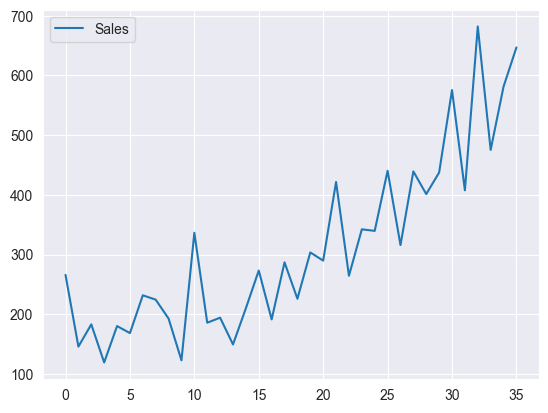

In [58]:
series=pd.read_csv("shampoo_sales.csv")
print(series.head())
series.plot()

# Exponential Moving Average 
## Isolate the values

In [59]:
time_period = 5  # moving averages window

alpha = 2 / (time_period + 1)  # smoothing factor

## Now verify the results by using the Pandas function
## https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html

In [60]:
exponential_moving_average_pandas = series['Sales'].ewm(span=time_period, adjust=False).mean()

### When adjust=False, the exponentially weighted function is calculated recursively:
### y0=x0
### yt=(1−α)yt−1+αxt,
### CONSEQUENTLY, the parameter "adjust" should be set to "False"
### ..........................................
### calculating EMA
### isolate the closing price

In [61]:
Sales = series['Sales']
exponential_moving_average = []  # list used to store the computed exponential moving averages
exponential_moving_average_value = 0  # used to store the value of the computed exponential moving average

for price in Sales:
    if (exponential_moving_average_value == 0):  # initialization
        exponential_moving_average_value = price
    else:
        exponential_moving_average_value = alpha * price + (1 - alpha) * exponential_moving_average_value

    exponential_moving_average.append(exponential_moving_average_value)

## Append the original data frame with the computed exponential moving average
## that is, add a column that will contain the values of the computed exponential moving averages

In [62]:
series = series.assign(Exponential_moving_average=pd.Series(exponential_moving_average, index=series.index))

## Plot the results

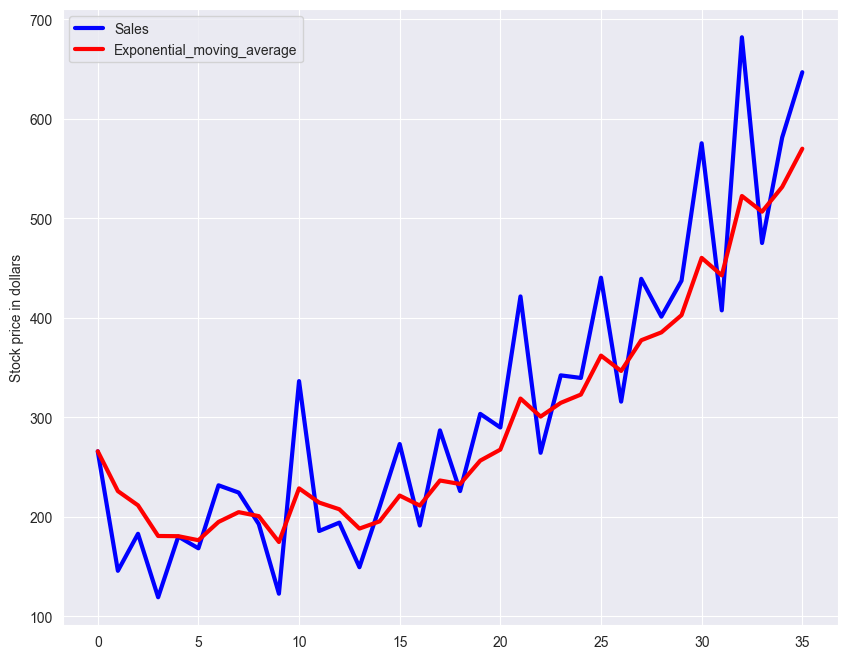

In [63]:
fig1 = plt.figure(figsize=(10, 8))
ax1 = fig1.add_subplot(111, ylabel='Stock price in dollars')
series['Sales'].plot(ax=ax1, color='b', lw=3, legend=True)
series['Exponential_moving_average'].plot(ax=ax1, color='r', lw=3, legend=True)
plt.savefig('exponential_moving_average.png')
plt.show()

## Compare the results

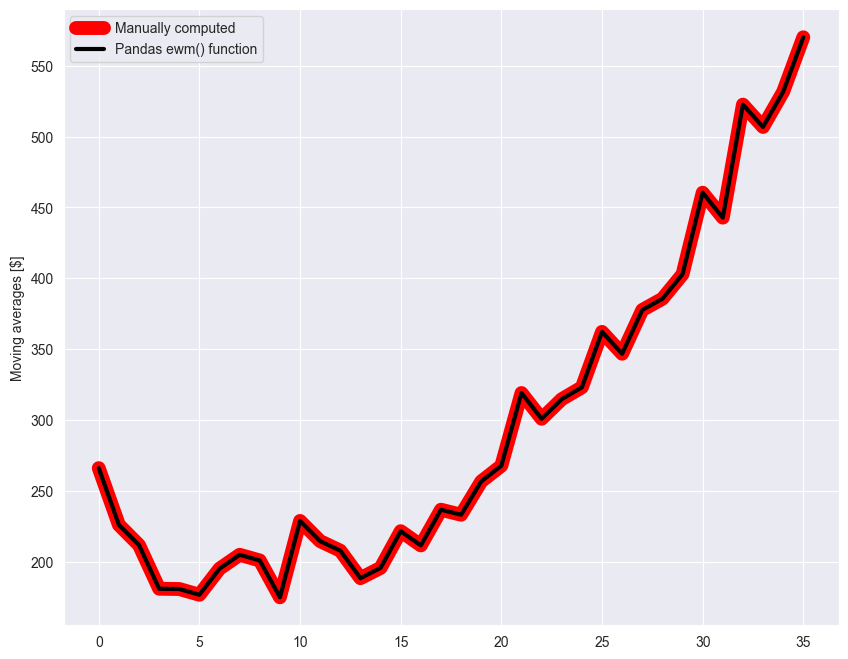

In [64]:
fig2 = plt.figure(figsize=(10, 8))
ax2 = fig2.add_subplot(111, ylabel='Moving averages [$]')
series['Exponential_moving_average'].plot(ax=ax2, color='r', lw=10, label='Manually computed', legend=True)
exponential_moving_average_pandas.plot(ax=ax2, color='k', lw=3, label='Pandas ewm() function', legend=True)
plt.savefig('exponential_moving_average_comparison.png')
plt.show()

# Arima

In [65]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as pyplot
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from numpy import sqrt
from sklearn.metrics import mean_squared_error
import math
def parser(x):
    return datetime.strptime('190' + x, '%Y-%m')

C:\Users\admin\AppData\Local\Temp\ipykernel_39288\39660168.py:1: FutureWarning:

The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.



<Axes: xlabel='Month'>

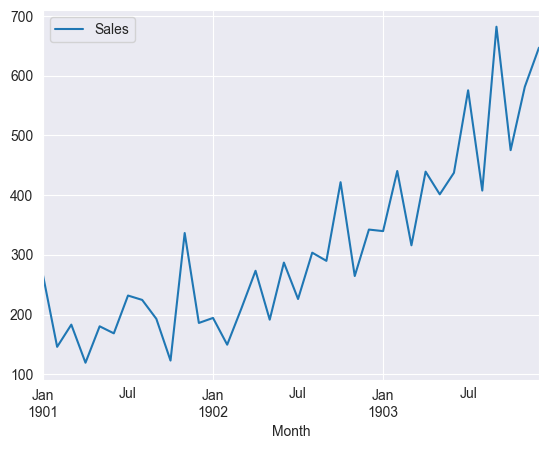

In [66]:
series=pd.read_csv("shampoo_sales.csv", header=0, parse_dates=[0], index_col=0, date_parser=parser)
series.plot()


##  We can see that the Shampoo Sales dataset has a clear trend. This suggests that the
##  time series is not stationary and will require differencing to make it stationary,
##  at least a difference order of 1.


##  Drawing autocorrection

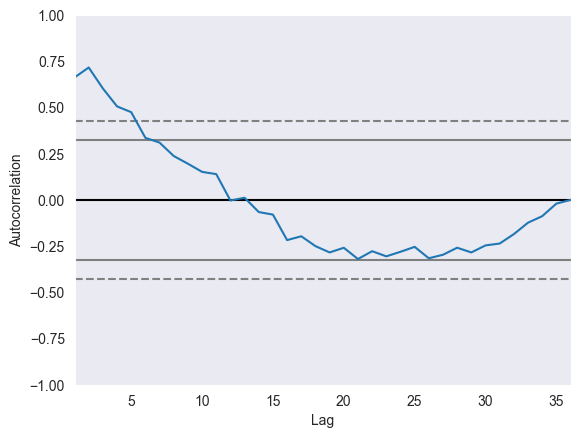

In [67]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
pyplot.show()

## Running the example, we can see that there is a positive correlation
## with the first 10-to-12 lags that is perhaps significant for the first 5 lags.
##
## This provides a hint: initiating the AR parameter of our model with a value of 5 could
## be a beneficial starting point.

## We’ll employ the ARIMA(5,1,0) configuration:
## 5 lags for autoregression (AR)
## 1st order differencing (I)
## No moving average term (MA)


## Keeping just month as period

In [68]:
series.index = series.index.to_period('M')

## Print(series.index)
## Fit model

In [69]:
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()

## Summary of fit model

In [70]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -198.485
Date:                Fri, 22 Mar 2024   AIC                            408.969
Time:                        15:53:06   BIC                            418.301
Sample:                    01-31-1901   HQIC                           412.191
                         - 12-31-1903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9014      0.247     -3.647      0.000      -1.386      -0.417
ar.L2         -0.2284      0.268     -0.851      0.395      -0.754       0.298
ar.L3          0.0747      0.291      0.256      0.7

## Line plot of residuals

<Axes: xlabel='Month'>

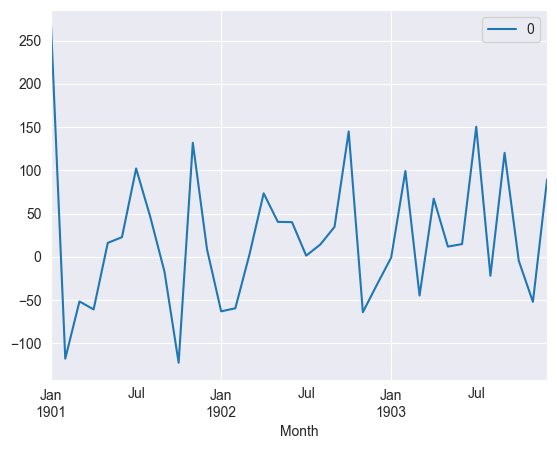

In [71]:
residuals = DataFrame(model_fit.resid)
residuals.plot()

## Pyplot.show()
## Density plot of residuals

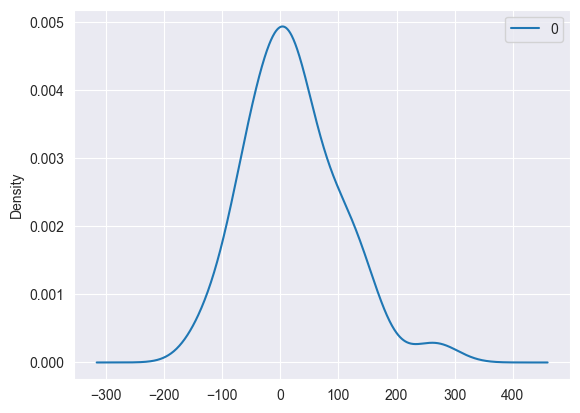

In [72]:
residuals.plot(kind='kde')
pyplot.show()

In [73]:
# summary stats of residuals
print(residuals.describe())

                0
count   36.000000
mean    21.936144
std     80.774430
min   -122.292030
25%    -35.040859
50%     13.147219
75%     68.848286
max    266.000000


## The ARIMA model can be used to forecast future time steps.
## evaluate an ARIMA model using a walk-forward validation
## split into train and test sets

In [74]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(5,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))

predicted=343.272180, expected=342.300000
predicted=293.329674, expected=339.700000


C:\Users\admin\AppData\Local\Temp\ipykernel_39288\388765252.py:15: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



predicted=368.668956, expected=440.400000
predicted=335.044741, expected=315.900000
predicted=363.220222, expected=439.300000
predicted=357.645324, expected=401.300000
predicted=443.047835, expected=437.400000
predicted=378.365674, expected=575.500000
predicted=459.415021, expected=407.600000
predicted=526.890876, expected=682.000000
predicted=457.231274, expected=475.300000
predicted=672.914943, expected=581.300000
predicted=531.541449, expected=646.900000


## Evaluate forecasts

In [75]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 89.021


## Plot forecasts against actual outcomes

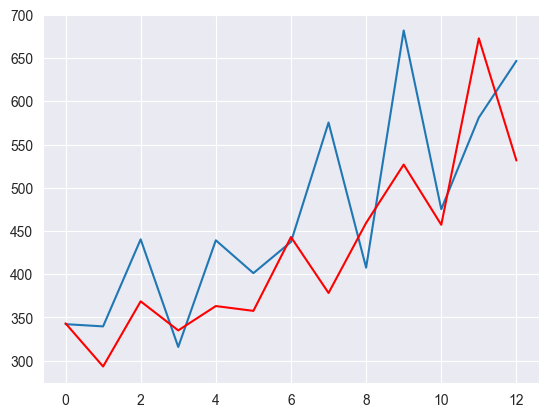

In [76]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

# Regression based on features extracted
## The distribution using histogram

C:\Users\admin\AppData\Local\Temp\ipykernel_39288\2201536172.py:8: FutureWarning:

The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.



            Sales
Month            
1901-01-01  266.0
1901-02-01  145.9
1901-03-01  183.1
1901-04-01  119.3
1901-05-01  180.3


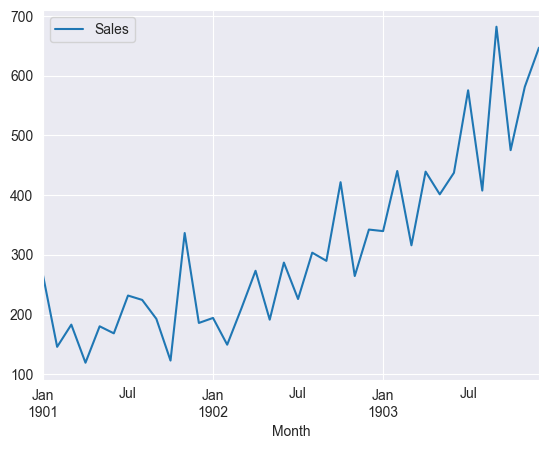

Text(0.5, 1.0, 'Distribution of Sales')

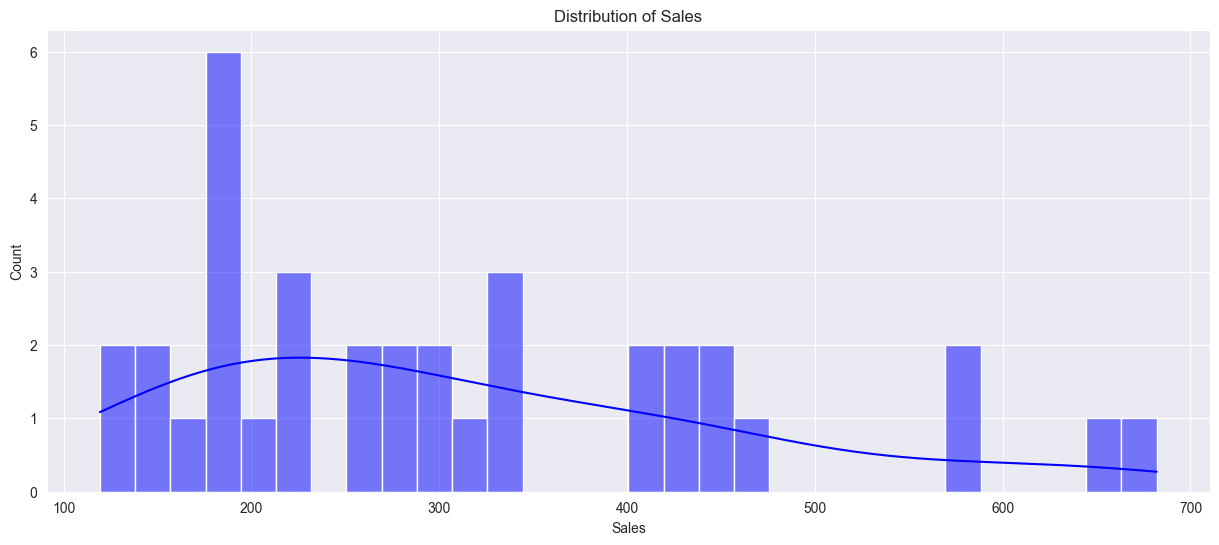

In [84]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pytz
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

series=pd.read_csv("shampoo_sales.csv", header=0, parse_dates=[0], index_col=0, date_parser=parser)
print(series.head())
series.plot()
plt.show()
fig, ax = plt.subplots(figsize=(15, 6))
sns.histplot(series["Sales"], kde = True, color = 'blue', bins = 30, ax = ax)
ax.set_title("Distribution of Sales")

## The Distribution of ‘Sales’  Using Box Plot:

In [78]:
series["Sales"].plot(kind="box", vert=False, title="Distribution of Sales",ax=ax)
plt.show()

## we need to take our target ‘Sales’  and manipulate it to turn it into a
## feature by creating a lag by shifting # our data. In other words, we will use
## the previous month’s sale to predict the present.

In [79]:
series["Sales.L1"] = series["Sales"].shift(2)
series.dropna(inplace = True)
print(series.head())

            Sales  Sales.L1
Month                      
1901-03-01  183.1     266.0
1901-04-01  119.3     145.9
1901-05-01  180.3     183.1
1901-06-01  168.5     119.3
1901-07-01  231.8     180.3


## Now we have a feature and a target, and we need to see if there
## is a relationship between these two things, the way to do this
## is the correlation.

In [80]:
print(series.corr())

             Sales  Sales.L1
Sales     1.000000  0.850743
Sales.L1  0.850743  1.000000


## Split Data
## splitting data into feature X and target Y
## Then splitting X and Y into train and test data
## Split the data into feature and target

In [81]:
target = "Sales"
y = series[target]
X = series.drop(columns= target)

## Split the data into train and test sets

In [82]:
cutoff = int(len(X) * 0.8)
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

## Building a linear regression model named model and fit it to our training data.

            y_test      y_pred
Month                         
1903-06-01   437.4  409.851151
1903-07-01   575.5  380.702357
1903-08-01   407.6  408.393712
1903-09-01   682.0  514.326567
1903-10-01   475.3  385.534920


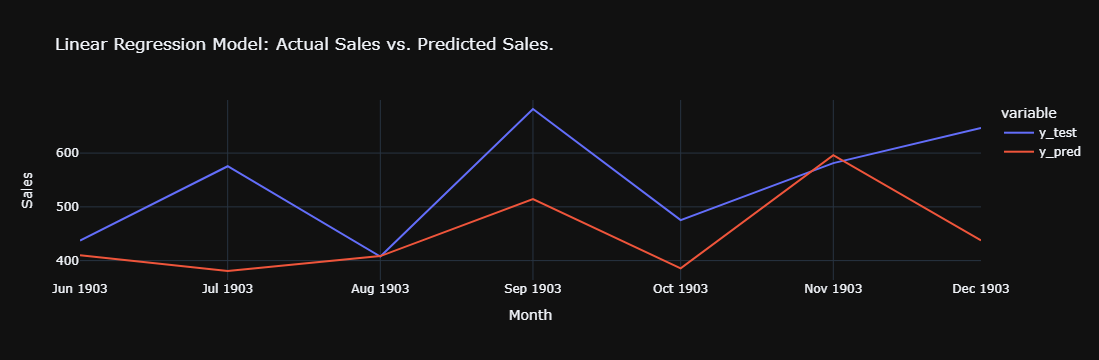

In [83]:
model = LinearRegression()
model.fit(X_train, y_train)
LinearRegression()
df_pred_test = pd.DataFrame(
             {
             "y_test": y_test,
             "y_pred": model.predict(X_test)
             }
)
print(df_pred_test.head())

fig = px.line(df_pred_test, labels= {"value": "Sales"}, title = "Linear Regression Model: Actual Sales vs. Predicted Sales.")
fig.show()